In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.metrics.pairwise import cosine_similarity
import random
import nltk

nltk.download('punkt')
nltk.download('stopwords')

C:\Users\Cynthia\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Cynthia\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Cynthia\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cynthia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cynthia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
movies = pd.read_csv(r'C:\Users\Cynthia\Downloads/udemy_courses.csv')
movies['course_title'] = movies['course_title'].str.strip().str[:-7]
movies['subject'] = movies['subject'].str.replace('|', ' ')
user_ratings = pd.read_csv(r'C:\Users\Cynthia\Downloads/ten_ratings.csv')
#user_ratings = user_ratings.drop(columns=['timestamp'])

<ipython-input-10-c95b4c341277>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies['subject'] = movies['subject'].str.replace('|', ' ')


All frequencies:
          Frequency
Word               
-               658
learn           502
trading         261
web             212
guitar          190
design          175
build           173
complete        172
piano           167
create          162


<AxesSubplot:xlabel='Word'>

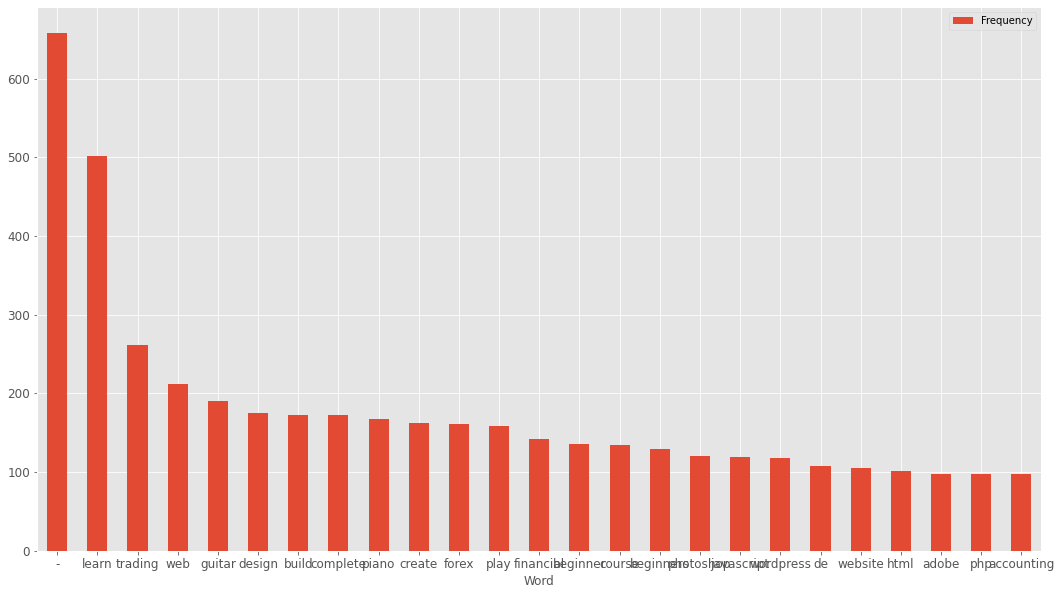

In [11]:
top_N = 25

txt = movies.course_title.str.lower().str.cat(sep=' ')

words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + [')', '(', ',', ':', "'s", '.', '!', '&', '?']
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies:')
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word').head(10)
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

matplotlib.style.use('ggplot')
rslt.plot.bar(rot=0, figsize=(18, 10), fontsize=12)

All frequencies:
             Frequency
Word                  
web               1200
development       1200
business          1195
finance           1195
musical            680
instruments        680
graphic            603
design             603


<AxesSubplot:xlabel='Word'>

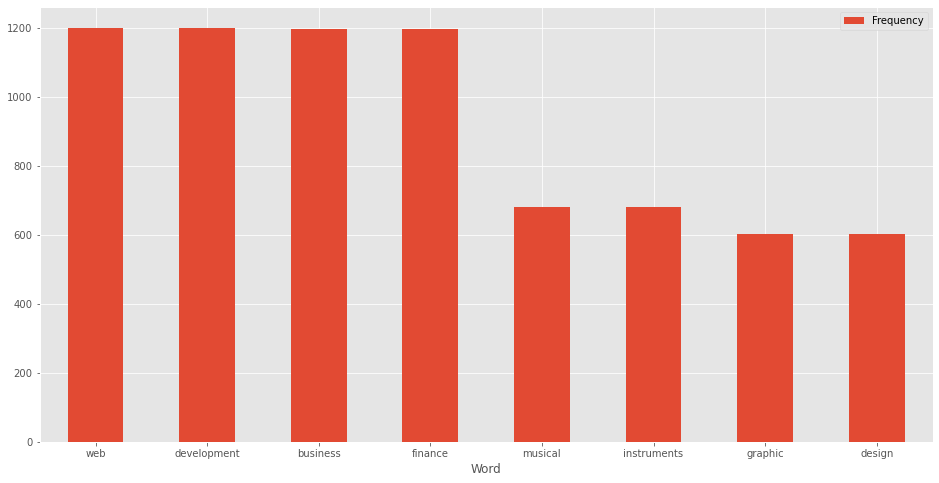

In [13]:
top_N = 25

txt = movies.subject.str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + [')', '(', ',', ':', "'s", '.', '!', '&', '?']
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies:')
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word').head(25)
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

matplotlib.style.use('ggplot')
rslt.plot.bar(rot=0, figsize=(16, 8), fontsize=10)

In [14]:
movies.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and Cons,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Exc,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


In [15]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(movies['subject'].values)
feature_names = vectorizer.get_feature_names()

In [18]:
genres_bow = pd.DataFrame(x.toarray(), columns=feature_names)
genres_bow['combined']= genres_bow.values.tolist()

In [19]:
movies['subject'] = genres_bow['combined']

In [22]:
def get_cossim(movieid, top):
    # Creating dataframe with only IDs and genres
    movies_to_search = movies[['course_id', 'subject']]
    # Remove the ID of the movie we are measuring distance to
    movies_to_search = movies_to_search[movies_to_search.movieId != movieid]
    # Saving distances to new column
    movies_to_search['dist'] = movies_to_search['subject'].apply(lambda x: cosine_similarity(np.array(x).reshape(1, -1), np.array(movies.loc[movies['movieId'] == movieid]['genres'].values[0]).reshape(1, -1)))
    # Remove the genres column
    movies_to_search = movies_to_search.drop(columns=['subject'])
    # Distance value is in the list inside of the list so we need to unpack it
    movies_to_search = movies_to_search.explode('dist').explode('dist')
    # Sort the data and return top values
    return movies_to_search.sort_values(by=['dist'], ascending=False)['courses_id'].head(top).values

In [24]:
def get_similar(userid):
    # Take all the movies watched by user
    movies_watched_by_user = user_ratings[user_ratings.user_id == user_id]
    # Only 4.5 or higher rating filtered
    movies_watched_by_user = movies_watched_by_user[movies_watched_by_user['rating'] > 0.08]
    # Taking top 20 with highest ratings
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(20))
    top_movies_user['watched_movieId'] = top_movies_user['movieId']
    top_movies_user = top_movies_user[['userId', 'watched_movieId']]
    # Find 5 similar movies for each of the selected above
    top_movies_user['similar'] = top_movies_user['watched_movieId'].apply(lambda x: (get_cossim(x, 5)))
    # Remove movies that user have already watched from recommendations
    result = [x for x in np.concatenate(top_movies_user['similar'].values, axis=0).tolist() if x not in top_movies_user.watched_movieId.values.tolist()]
    return result

In [25]:
def get_top(id, top):
    # taking movies that user may like
    smlr = get_similar(id)    
    # Calculating mean rationg for every movie
    movie_data = pd.merge(user_ratings, movies, on='book_id')
    ratings_mean_count = pd.DataFrame(movie_data.groupby('book_id')['rating'].mean())
    ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('book_id')['rating'].count())
    # Sorting movies with 10 or more ratings by users
    ratings_mean_count = ratings_mean_count[ratings_mean_count['rating_counts'] > 10]
    # Returning top N movies sorted by rating
    return ratings_mean_count[ratings_mean_count.index.isin(smlr)].sort_values(by=['rating'], ascending=False).head(top)

In [26]:
df = user_ratings

In [40]:
df.rating*100
print(max(df.rating))

0.4285714328289032


In [41]:
user_ids = df["user_id"].unique().tolist()
# Reassign user IDs
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["book_id"].unique().tolist()
# Reassign movie IDs
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["book_id"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 20, Number of Movies: 3672, Min rating: 0.0, Max rating: 0.4285714328289032


In [42]:
 df = df.sample(frac=1, random_state=42)
x = df[["user_id", "book_id"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [32]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0005)
)

In [33]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15


InvalidArgumentError:  indices[18] = 20 is not in [0, 20)
	 [[node recommender_net_1/embedding_4/embedding_lookup (defined at <ipython-input-32-8afbfd9b999c>:25) ]] [Op:__inference_train_function_1043]

Errors may have originated from an input operation.
Input Source operations connected to node recommender_net_1/embedding_4/embedding_lookup:
 recommender_net_1/embedding_4/embedding_lookup/632 (defined at C:\Users\Cynthia\anaconda3\lib\contextlib.py:113)

Function call stack:
train_function


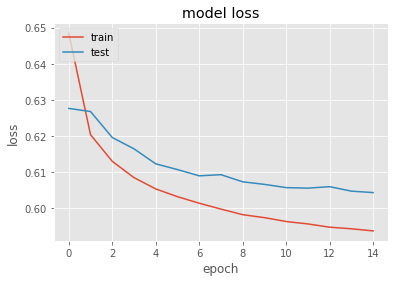

In [50]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [62]:
model.save_weights(r"C:\Users\Cynthia\Downloads\my_h5_model.h5")


In [38]:
df = user_ratings

In [39]:
top = get_top(user_id, 20)
content_rec = top.index.values.tolist()

In [40]:
movie_df = pd.read_csv(r'C:\Users\Cynthia\Downloads/movies.csv') 

# Searching for movies that user already watched
movies_watched_by_user = df[df.userId == user_id]
# Searching for movies that user haven't watched yet
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
# Predicting ratings for movies
ratings = model.predict(user_movie_array).flatten()
# Sorting predicted ratings and taking top 20
top_ratings_indices = ratings.argsort()[-20:][::-1]
# Getting the actual IDs for movies
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]


In [41]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 10)
print("Movies with high ratings from user")
print("----" * 10)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(10)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 10)
print("Top 10 movie recommendations")
print("----" * 10)
# Случайным образом выбираем 10 фильмов из рекомендаций
to_recommend = random.sample((content_rec + recommended_movie_ids), 10)
recommended_movies = movie_df[movie_df["movieId"].isin(to_recommend)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 16
Movies with high ratings from user
----------------------------------------
Blade Runner (1982) : Action|Sci-Fi|Thriller
Fargo (1996) : Comedy|Crime|Drama|Thriller
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Brazil (1985) : Fantasy|Sci-Fi
Full Metal Jacket (1987) : Drama|War
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Memento (2000) : Mystery|Thriller
Spirited Away (Sen to Chihiro no kamikakushi) (2001) : Adventure|Animation|Fantasy
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Dark Knight Rises, The (2012) : Action|Adventure|Crime|IMAX
----------------------------------------
Top 10 movie recommendations
----------------------------------------
Streetcar Named Desire, A (1951) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Seventh Seal, The (Sjunde inseglet, Det) (1957) : Drama
Glory (1989) : Drama|War
Manhattan (1979) : Comedy|Drama|Romance
Miller's Crossing (1990) : Crime|Drama|Fil